In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# import optuna
import time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Data Loading

In [2]:
df_train = pd.read_csv('..\\Dataset\\raw\\train.csv')
df_test = pd.read_csv('..\\Dataset\\raw\\test.csv')

# EDA

In [3]:
df_train.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1.0,0.0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1.0,0.0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1.0,0.0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1.0,0.0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1.0,1.0,170843.07,0


In [4]:
# Dataset Dimension
df_train.shape

(165034, 14)

In [5]:
# Missing Values Check
df_train.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
# Descriptive statistics of numerical features
df_train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [7]:
# Determine the continous numerical features
num_cont_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']

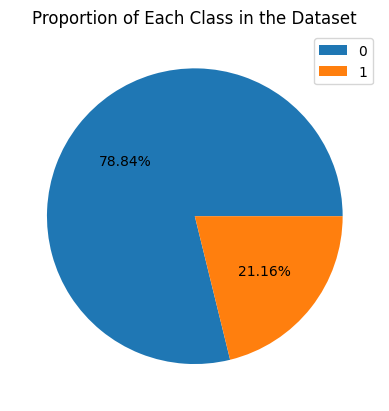

In [8]:
# Count frequency each class
category_counts = df_train['Exited'].value_counts()
size = df_train['Exited'].value_counts()

# Create Bar Chart
plt.pie(size, autopct="%.2f%%")
plt.legend(labels=category_counts.index)
plt.title('Proportion of Each Class in the Dataset')
plt.show()


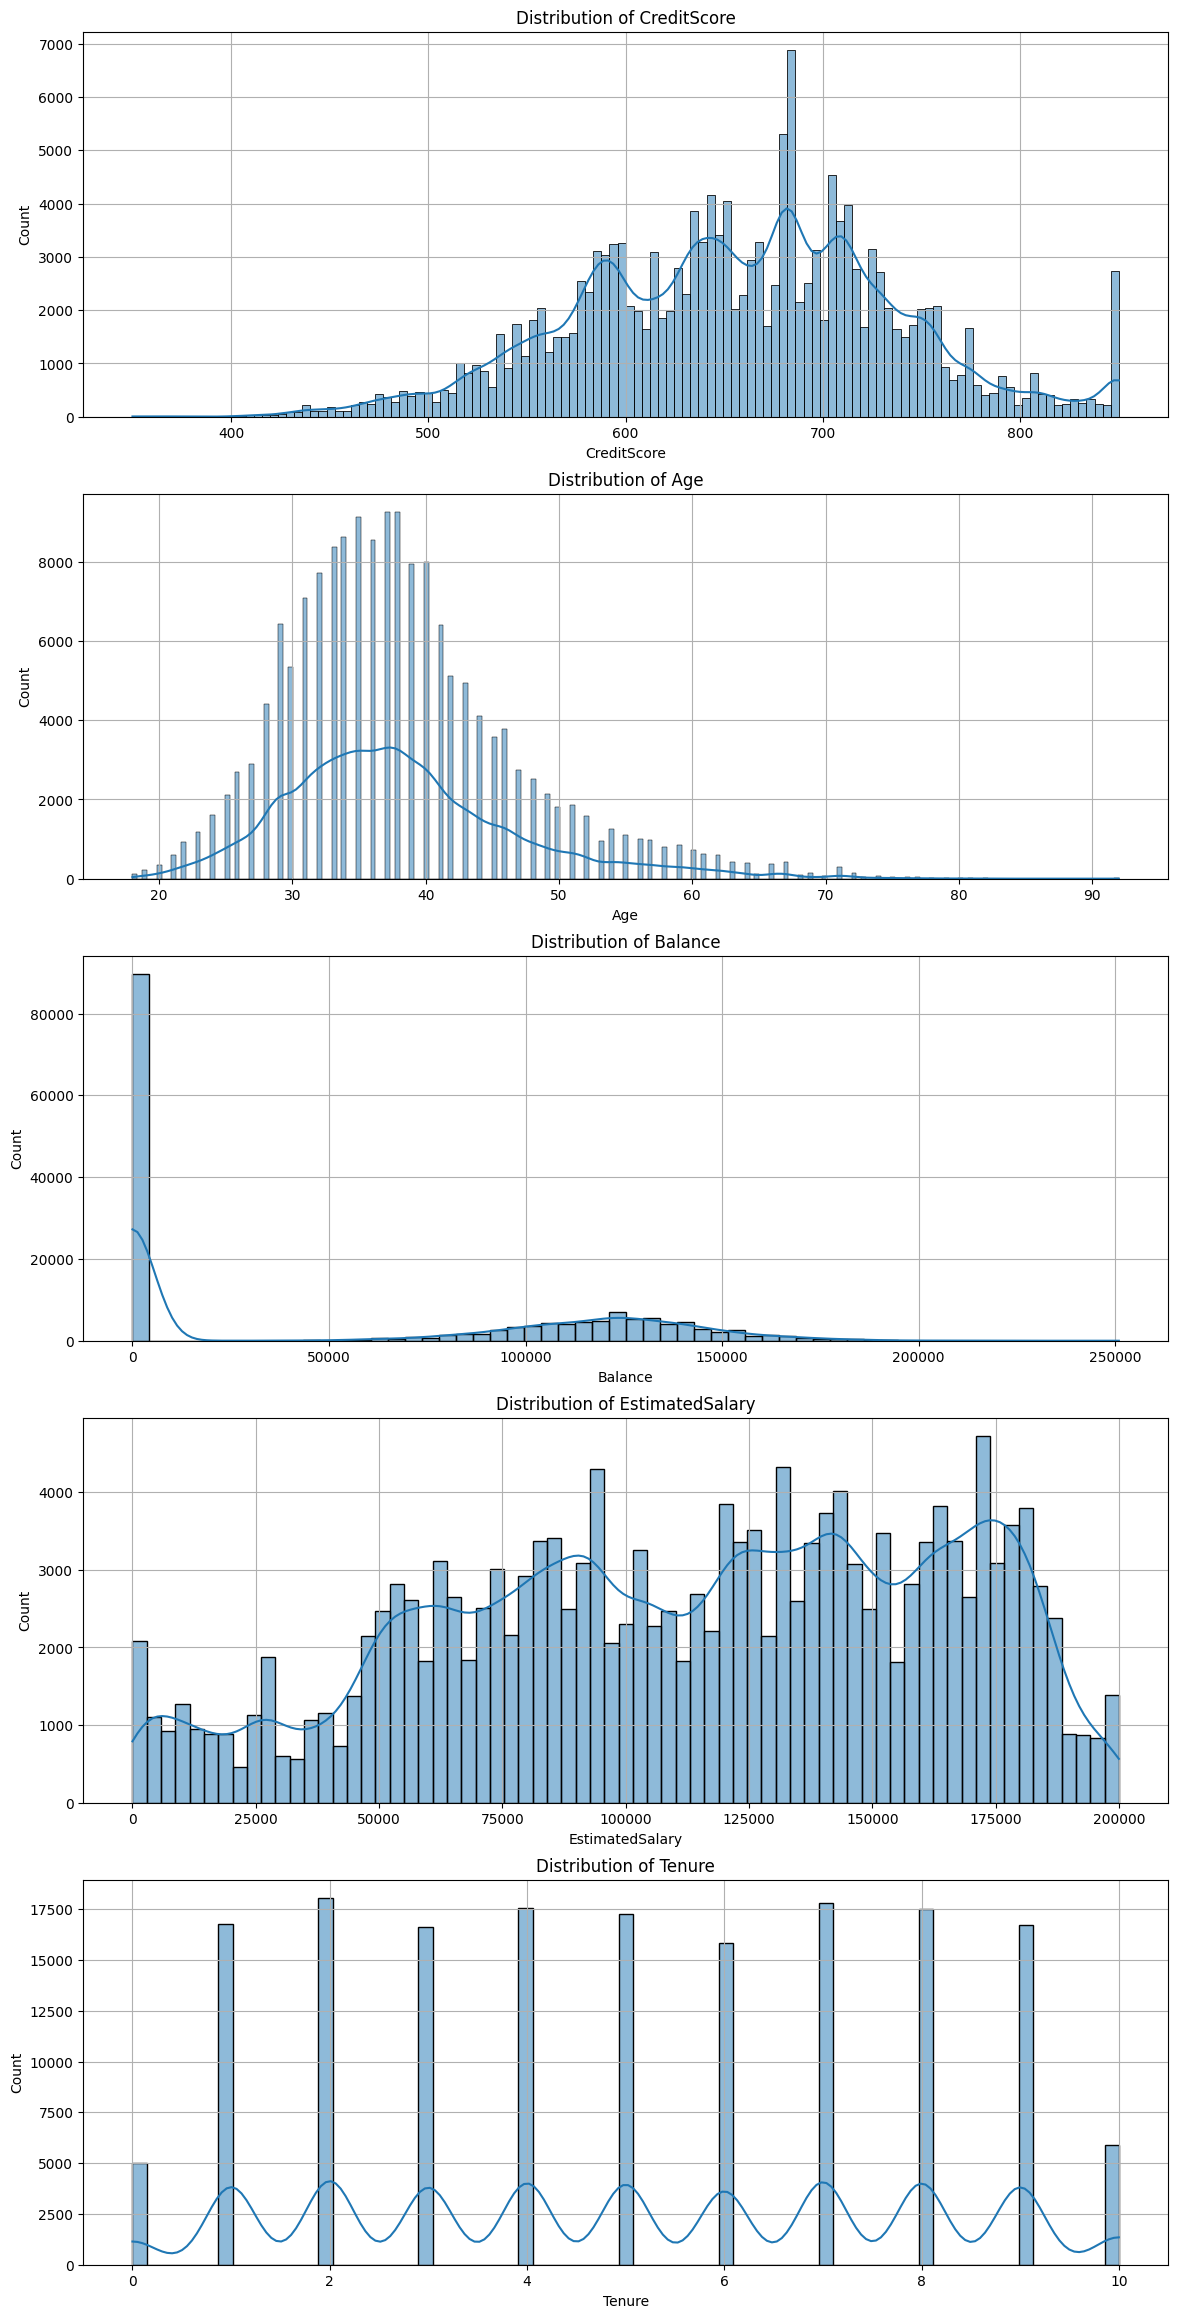

In [9]:
# Visualization of Numerical Features Distribution
fig, axes = plt.subplots(5, 1, figsize=(14,29))
for i, col in enumerate(num_cont_features):
    sns.histplot(data=df_train[col], kde=True, ax=axes[i])
    axes[i].set_title('Distribution of ' + col)
    axes[i].grid(True)

# Preprocessing

In [10]:
df_train.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [11]:
def preprocessing(df):
    df_processed = df_train.copy()

    # drop non-informative column
    df_processed.drop(columns=['id', 'CustomerId', 'Surname'], inplace=True)
    
    # encode geography & gender
    df_processed = pd.get_dummies(df_processed, columns=['Geography', 'Gender'])

    # split data into feature & target
    X = df_processed.drop(columns='Exited')
    y = df_processed['Exited']
    print(df_processed.shape)

    # split data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # change the scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # change to array
    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

    return X_train, X_test, y_train, y_test


In [12]:
X_train, X_test, y_train, y_test = preprocessing(df_train)

(165034, 14)


In [13]:
# Determine the input and output dimensions
X_dim = df_train.drop(columns='Exited').shape[1]
y_dim = df_train['Exited'].nunique()

# Modelling

In [14]:
# Dataframe for evaluation result each model
eval_columns = ['Model', 'Accuracy', 'F1', 'ROC AUC']
eval_results = pd.DataFrame(columns=eval_columns)
eval_results

,Model,Accuracy,F1,ROC AUC


## Deep Learning

### NODE : Neural Oblivious Decision Ensemble

In [15]:
class DeepObliviousDecisionTreeLayer(nn.Module):
    def __init__(self, input_dim, num_trees, tree_depth, hidden_dim):
        super(DeepObliviousDecisionTreeLayer, self).__init__()
        self.num_trees = num_trees
        self.tree_depth = tree_depth
        self.hidden_dim = hidden_dim
        
        # Define a deeper architecture with hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(tree_depth):
            self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
            input_dim = hidden_dim 
        
        self.output_layer = nn.Linear(hidden_dim, num_trees)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = F.relu(layer(x)) 
        
        # Apply the output layer
        out = torch.sigmoid(self.output_layer(x))
        return out

class NODE(nn.Module):
    def __init__(self, input_dim, output_dim, num_trees, tree_depth, hidden_dim):
        super(NODE, self).__init__()
        self.tree_layer = DeepObliviousDecisionTreeLayer(input_dim, num_trees=num_trees, tree_depth=tree_depth, hidden_dim=hidden_dim)
        
        # Additional fully connected layers to make it deeper
        self.fc1 = nn.Linear(num_trees, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.tree_layer(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
def train_and_evaluate_model(model, model_name, X_train, X_test, y_train, y_test, num_epochs=100, learning_rate=0.001, batch_size=256):
    # Define start time recorder
    start_time = time.time()

    # Create data loaders for batch processing
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    def eval_model(model, data_loader):
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for batch_x, batch_y in data_loader:
                outputs = model(batch_x)
                y_prob = F.softmax(outputs, dim=1)
                y_true.append(batch_y)
                y_pred.append(y_prob)
        
        y_true = torch.cat(y_true).numpy()
        y_pred = torch.cat(y_pred).numpy()

        # Convert probabilities to class predictions
        y_pred_classes = torch.argmax(torch.from_numpy(y_pred), dim=1).numpy()

        # Compute accuracy and F1 score
        accuracy = accuracy_score(y_true, y_pred_classes)
        f1 = f1_score(y_true, y_pred_classes, average='weighted')

        # Compute AUC-ROC score for test data (binary classification)
        if y_pred.shape[1] == 2:
            y_prob_positive = y_pred[:, 1]
            auc_roc = roc_auc_score(y_true, y_prob_positive)
        else:
            auc_roc = 'N/A'

        return accuracy, f1, auc_roc

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        batch_auc_roc_scores = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate AUC-ROC for the current batch (only for binary classification)
            if outputs.size(1) == 2:
                y_prob_batch = F.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy()
                
                # Check if there is more than one class in the batch
                if len(np.unique(batch_y.cpu().numpy())) > 1:
                    auc_roc_batch = roc_auc_score(batch_y.cpu().numpy(), y_prob_batch)
                    batch_auc_roc_scores.append(auc_roc_batch)
                else:
                    print('AUC-ROC calculation skipped for batch with only one class')
        
        # Calculate average AUC-ROC for the epoch
        avg_batch_auc_roc = sum(batch_auc_roc_scores) / len(batch_auc_roc_scores) if batch_auc_roc_scores else 'N/A'
        
        # Print information every 10 epochs
        if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Avg Batch AUC-ROC: {avg_batch_auc_roc:.4f}' if avg_batch_auc_roc != 'N/A' else f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Final evaluation at the end of training
    print('Final Evaluation:')
    final_train_accuracy, final_train_f1, final_train_auc_roc = eval_model(model, train_loader)
    final_test_accuracy, final_test_f1, final_test_auc_roc = eval_model(model, test_loader)

    print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
    print(f'Final Train F1 Score: {final_train_f1:.4f}')
    print(f'Final Train AUC-ROC Score: {final_train_auc_roc:.4f}' if final_train_auc_roc != 'N/A' else 'Final Train AUC-ROC Score: N/A')
    print(f'Final Test Accuracy: {final_test_accuracy:.4f}')
    print(f'Final Test F1 Score: {final_test_f1:.4f}')
    print(f'Final Test AUC-ROC Score: {final_test_auc_roc:.4f}' if final_test_auc_roc != 'N/A' else 'Final Test AUC-ROC Score: N/A')

    # Define end time recording
    end_time = time.time()
    # Calculate the execution time
    execution_time = end_time - start_time

    result = pd.DataFrame([{'Model':model_name, 'Accuracy':final_test_accuracy, 'F1':final_test_f1, 'ROC AUC':final_test_auc_roc, 'Execution Time':execution_time}])
    
    return result

In [17]:
def train_eval_non_scratch(model, model_name, X_train, X_test, y_train, y_test):
    # Define start time recording
    start_time = time.time()
    if not isinstance(model, TabNetClassifier):
        model.fit(X_train, y_train)
    else : 
        model.fit(X_train=X_train, 
                y_train=y_train, 
                eval_set=[(X_test, y_test)],
                eval_metric=['accuracy', 'auc'],
                max_epochs=100, 
                patience=10,
                batch_size=256,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False)
    # Predict
    y_pred = model.predict(X_test)
    # Eval
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"F1: {f1:.4f}")
    y_proba = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC: {roc_auc:.4f}")
    # Define end time recording
    end_time = time.time()
    # Calculate the execution time
    execution_time = end_time - start_time

    result = pd.DataFrame([{'Model':model_name, 'Accuracy':accuracy, 'F1':f1, 'ROC AUC':roc_auc, 'Execution Time':execution_time}])

    return result

In [18]:
input_dim = X_dim
output_dim = y_dim
NODE_model = NODE(input_dim, output_dim, num_trees=56, tree_depth=6, hidden_dim=128)

In [19]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

In [20]:
result = train_and_evaluate_model(NODE_model, "NODE Classifier", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.3212, Avg Batch AUC-ROC: 0.8893
Epoch [20/100], Loss: 0.3169, Avg Batch AUC-ROC: 0.8930
Epoch [30/100], Loss: 0.3107, Avg Batch AUC-ROC: 0.8975
Epoch [40/100], Loss: 0.3015, Avg Batch AUC-ROC: 0.9047
Epoch [50/100], Loss: 0.2896, Avg Batch AUC-ROC: 0.9139
Epoch [60/100], Loss: 0.2755, Avg Batch AUC-ROC: 0.9234
Epoch [70/100], Loss: 0.2623, Avg Batch AUC-ROC: 0.9317
Epoch [80/100], Loss: 0.2478, Avg Batch AUC-ROC: 0.9398
Epoch [90/100], Loss: 0.2354, Avg Batch AUC-ROC: 0.9463
Epoch [100/100], Loss: 0.2248, Avg Batch AUC-ROC: 0.9516
Final Evaluation:
Final Train Accuracy: 0.9090
Final Train F1 Score: 0.9078
Final Train AUC-ROC Score: 0.9571
Final Test Accuracy: 0.8393
Final Test F1 Score: 0.8369
Final Test AUC-ROC Score: 0.8275


C:\Users\fadhil\AppData\Local\Temp\ipykernel_21948\1212388360.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_results = pd.concat([result, eval_results], ignore_index=True)


#### Optuna

In [21]:
# def NODE_objectives(trial):
#     num_trees = trial.suggest_int('num_trees', 10, 100)
#     tree_depth = trial.suggest_int('tree_depth', 5, 10)

#     NODE_model = NODE(
#         input_dim = X_dim,
#         output_dim = y_dim,
#         num_trees = num_trees,
#         tree_depth = tree_depth,
#         hidden_dim = 128
#     )
    
#     avg_auc_roc = train_model(NODE_model, X_train_t, X_test_t, y_train_t, y_test_t)

#     return avg_auc_roc

In [22]:
# study = optuna.create_study(direction='maximize')
# study.optimize(NODE_objectives, n_trials=50)
# trial = study.best_trial

# print('Value: ', trial.value)
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

### Tab-Transformer

In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion),
            nn.ReLU(),
            nn.Linear(forward_expansion, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is expected to have shape [batch_size, sequence_length, embed_size]
        attention = self.attention(x, x, x)[0]
        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, embed_size, num_heads, forward_expansion, dropout):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_size)
        self.transformer_block = TransformerBlock(
            embed_size=embed_size,
            heads=num_heads,
            dropout=dropout,
            forward_expansion=forward_expansion
        )
        self.fc = nn.Linear(embed_size, output_dim)

    def forward(self, x):
        # Add sequence dimension
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.transformer_block(x)
        x = x.squeeze(1)
        out = self.fc(x)
        return out

In [24]:
# Define Tab-Transfomer Model
TabTR_model = TabularTransformer(
    input_dim=input_dim,
    output_dim=output_dim,
    embed_size=32,
    num_heads=4,
    forward_expansion=128,
    dropout=0.1
)

In [25]:
result = train_and_evaluate_model(TabTR_model, "Tab-Transformer", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.3260, Avg Batch AUC-ROC: 0.8847
Epoch [20/100], Loss: 0.3240, Avg Batch AUC-ROC: 0.8863
Epoch [30/100], Loss: 0.3231, Avg Batch AUC-ROC: 0.8872
Epoch [40/100], Loss: 0.3225, Avg Batch AUC-ROC: 0.8873
Epoch [50/100], Loss: 0.3220, Avg Batch AUC-ROC: 0.8880
Epoch [60/100], Loss: 0.3216, Avg Batch AUC-ROC: 0.8880
Epoch [70/100], Loss: 0.3210, Avg Batch AUC-ROC: 0.8887
Epoch [80/100], Loss: 0.3212, Avg Batch AUC-ROC: 0.8885
Epoch [90/100], Loss: 0.3204, Avg Batch AUC-ROC: 0.8891
Epoch [100/100], Loss: 0.3205, Avg Batch AUC-ROC: 0.8891
Final Evaluation:
Final Train Accuracy: 0.8668
Final Train F1 Score: 0.8586
Final Train AUC-ROC Score: 0.8911
Final Test Accuracy: 0.8653
Final Test F1 Score: 0.8574
Final Test AUC-ROC Score: 0.8894


### TabNet

In [26]:
# Define TabNet Model
TabNet_model = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                         optimizer_params=dict(lr=2e-2),
                         scheduler_fn=torch.optim.lr_scheduler.StepLR,
                         scheduler_params=dict(step_size=10, gamma=0.9),
                         mask_type='sparsemax')

result = train_eval_non_scratch(TabNet_model, "Tabnet", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.37821 | val_0_accuracy: 0.85109 | val_0_auc: 0.86411 |  0:00:15s
epoch 1  | loss: 0.34033 | val_0_accuracy: 0.86233 | val_0_auc: 0.87999 |  0:00:32s
epoch 2  | loss: 0.33363 | val_0_accuracy: 0.86251 | val_0_auc: 0.88561 |  0:00:48s
epoch 3  | loss: 0.33354 | val_0_accuracy: 0.86079 | val_0_auc: 0.87699 |  0:01:04s
epoch 4  | loss: 0.33314 | val_0_accuracy: 0.86348 | val_0_auc: 0.88528 |  0:01:20s
epoch 5  | loss: 0.33248 | val_0_accuracy: 0.86221 | val_0_auc: 0.88326 |  0:01:36s
epoch 6  | loss: 0.33999 | val_0_accuracy: 0.85476 | val_0_auc: 0.88092 |  0:01:52s
epoch 7  | loss: 0.33482 | val_0_accuracy: 0.84846 | val_0_auc: 0.86411 |  0:02:08s
epoch 8  | loss: 0.34372 | val_0_accuracy: 0.85388 | val_0_auc: 0.8747  |  0:02:24s
epoch 9  | loss: 0.33783 | val_0_accuracy: 0.86309 | val_0_auc: 0.88461 |  0:02:40s
epoch 10 | loss: 0.33656 | val_0_accuracy: 0.85636 | val_0_auc: 0.87911 |  0:02:56s
epoch 11 | loss: 0.33552 | val_0_accuracy: 0.86436 | val_0_auc: 0.8846  |  0

c:\Users\fadhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.8625
F1: 0.8577
ROC AUC: 0.8856


### SAINT : Self Attention & Intersample Attention

In [27]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, attn_dim, num_heads, dropout=0.1):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.attn_dim = attn_dim
        
        self.query = nn.Linear(input_dim, attn_dim * num_heads)
        self.key = nn.Linear(input_dim, attn_dim * num_heads)
        self.value = nn.Linear(input_dim, attn_dim * num_heads)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(attn_dim * num_heads, input_dim)
        
    def forward(self, x):
        if len(x.size()) == 2:  # If input has 2 dimensions
            x = x.unsqueeze(1)  # Add a sequence dimension: [batch_size, 1, input_dim]

        batch_size, seq_len, _ = x.size()
        
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.attn_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.output_layer(attn_output)

        return output

class IntersampleAttention(nn.Module):
    def __init__(self, input_dim, attn_dim, num_heads, dropout=0.1):
        super(IntersampleAttention, self).__init__()
        self.num_heads = num_heads
        self.attn_dim = attn_dim
        
        self.query = nn.Linear(input_dim, attn_dim * num_heads)
        self.key = nn.Linear(input_dim, attn_dim * num_heads)
        self.value = nn.Linear(input_dim, attn_dim * num_heads)
        
        self.attn_dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(attn_dim * num_heads, input_dim)
        
    def forward(self, x):
        if len(x.size()) == 2:  # If input has 2 dimensions
            x = x.unsqueeze(1)  # Add a sequence dimension: [batch_size, 1, input_dim]

        batch_size, seq_len, _ = x.size()
        
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.attn_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.attn_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, V)

        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.output_layer(attn_output)

        return output

class SAINT(nn.Module):
    def __init__(self, input_dim, output_dim, attn_dim, num_heads, num_layers, hidden_dim, dropout=0.1):
        super(SAINT, self).__init__()
        
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        
        self.self_attn_layers = nn.ModuleList([
            SelfAttention(hidden_dim, attn_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.intersample_attn_layers = nn.ModuleList([
            IntersampleAttention(hidden_dim, attn_dim, num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        
        for self_attn, intersample_attn in zip(self.self_attn_layers, self.intersample_attn_layers):
            x = self_attn(x)
            x = intersample_attn(x)
        
        x = torch.mean(x, dim=1)  # Global average pooling
        
        output = self.output_layer(x)
        
        return output

In [28]:
SAINT_model = SAINT(
    input_dim = X_dim,
    output_dim = y_dim,
    attn_dim = 16,
    num_heads = 2,
    num_layers = 3,
    hidden_dim = 64
)

In [31]:
result = train_and_evaluate_model(SAINT_model, "SAINT", X_train_t, X_test_t, y_train_t, y_test_t)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Epoch [10/100], Loss: 0.3663, Avg Batch AUC-ROC: 0.8623
Epoch [20/100], Loss: 0.3649, Avg Batch AUC-ROC: 0.8639
Epoch [30/100], Loss: 0.3623, Avg Batch AUC-ROC: 0.8641
Epoch [40/100], Loss: 0.3637, Avg Batch AUC-ROC: 0.8650
Epoch [50/100], Loss: 0.3624, Avg Batch AUC-ROC: 0.8655
Epoch [60/100], Loss: 0.3611, Avg Batch AUC-ROC: 0.8662
Epoch [70/100], Loss: 0.3627, Avg Batch AUC-ROC: 0.8649
Epoch [80/100], Loss: 0.3618, Avg Batch AUC-ROC: 0.8658
Epoch [90/100], Loss: 0.3625, Avg Batch AUC-ROC: 0.8658
Epoch [100/100], Loss: 0.3614, Avg Batch AUC-ROC: 0.8661
Final Evaluation:
Final Train Accuracy: 0.8624
Final Train F1 Score: 0.8472
Final Train AUC-ROC Score: 0.8901
Final Test Accuracy: 0.8612
Final Test F1 Score: 0.8460
Final Test AUC-ROC Score: 0.8880


## Machine Learning

### Random Forest

In [32]:
# Define Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(rf_model, "Random Forest", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.8577
F1: 0.8502
ROC AUC: 0.8743


### LightGBM

In [33]:
# Define LightGBM Model
lgbm_model = LGBMClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(lgbm_model, "LightGBM", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

[LightGBM] [Info] Number of positive: 27966, number of negative: 104061
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211820 -> initscore=-1.313988
[LightGBM] [Info] Start training from score -1.313988
Accuracy: 0.8684
F1: 0.8614
ROC AUC: 0.8909


### XGBoost

In [34]:
# Define XGBoost Model
xgb_model = XGBClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(xgb_model, "XGBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Accuracy: 0.8662
F1: 0.8595
ROC AUC: 0.8886


### CatBoost

In [35]:
# Define CatBoost Model
cb_model = CatBoostClassifier(random_state=42)

# Train & Eval with function
result = train_eval_non_scratch(cb_model, "CatBoost", X_train, X_test, y_train, y_test)
eval_results = pd.concat([result, eval_results], ignore_index=True)

Learning rate set to 0.082881
0:	learn: 0.6180166	total: 149ms	remaining: 2m 28s
1:	learn: 0.5603249	total: 167ms	remaining: 1m 23s
2:	learn: 0.5124327	total: 179ms	remaining: 59.6s
3:	learn: 0.4767282	total: 192ms	remaining: 47.7s
4:	learn: 0.4484816	total: 204ms	remaining: 40.7s
5:	learn: 0.4261401	total: 226ms	remaining: 37.4s
6:	learn: 0.4087262	total: 256ms	remaining: 36.3s
7:	learn: 0.3946403	total: 275ms	remaining: 34.1s
8:	learn: 0.3825969	total: 290ms	remaining: 31.9s
9:	learn: 0.3730406	total: 301ms	remaining: 29.8s
10:	learn: 0.3655105	total: 313ms	remaining: 28.1s
11:	learn: 0.3594527	total: 324ms	remaining: 26.7s
12:	learn: 0.3544573	total: 337ms	remaining: 25.6s
13:	learn: 0.3498747	total: 350ms	remaining: 24.6s
14:	learn: 0.3462292	total: 362ms	remaining: 23.8s
15:	learn: 0.3430676	total: 373ms	remaining: 23s
16:	learn: 0.3406508	total: 384ms	remaining: 22.2s
17:	learn: 0.3380578	total: 396ms	remaining: 21.6s
18:	learn: 0.3360874	total: 408ms	remaining: 21s
19:	learn: 0.

# Evaluation

In [36]:
eval_results

,Model,Accuracy,F1,ROC AUC,Execution Time
0,CatBoost,0.867846,0.860211,0.890722,11.289777
1,XGBoost,0.866210,0.859459,0.888567,0.610977
2,LightGBM,0.868422,0.861445,0.890918,0.514137
3,Random Forest,0.857727,0.850156,0.874260,16.229266
4,SAINT,0.861151,0.845999,0.887991,1090.978791
5,Tabnet,0.862514,0.857692,0.885605,222.549400
6,Tab-Transformer,0.865332,0.857442,0.889442,655.674388
7,NODE Classifier,0.839307,0.836943,0.827485,890.754897
